In [15]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

In [16]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

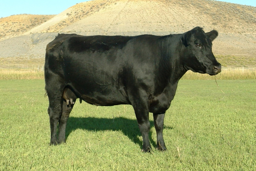

In [17]:
urls = search_images('Vaca Angus', max_images=1)
urls[0]
from fastdownload import download_url
dest = 'angus.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

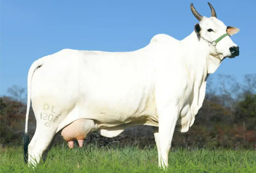

In [18]:
download_url(search_images('vaca Nelore', max_images=1)[0], 'Nelore.jpg', show_progress=False)
Image.open('Nelore.jpg').to_thumb(256,256)

In [19]:
searches = 'Vaca Angus','Vaca Nelore','Vaca Brangus'
path = Path('cow_breed')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [20]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

37

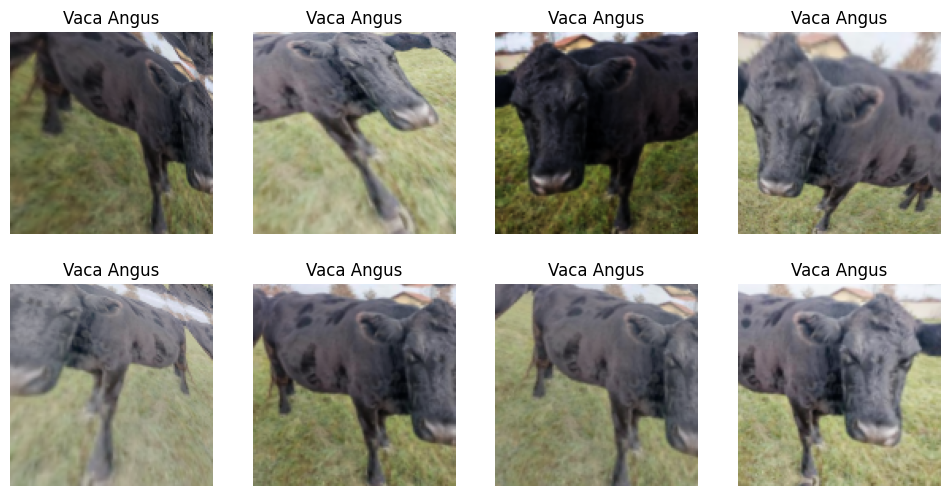

In [21]:
cows = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)
cows = cows.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cows.dataloaders(path)
dls.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.654033,0.871867,0.307263,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.921037,0.718762,0.262570,00:02
1,0.848719,0.688588,0.206704,00:02
2,0.782740,0.674035,0.234637,00:02
3,0.710056,0.681558,0.223464,00:02
4,0.655220,0.649194,0.229050,00:02


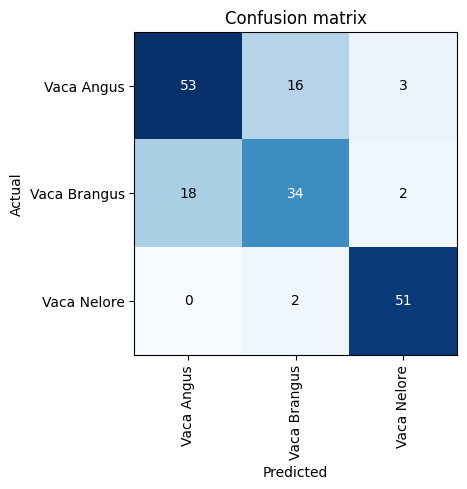

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

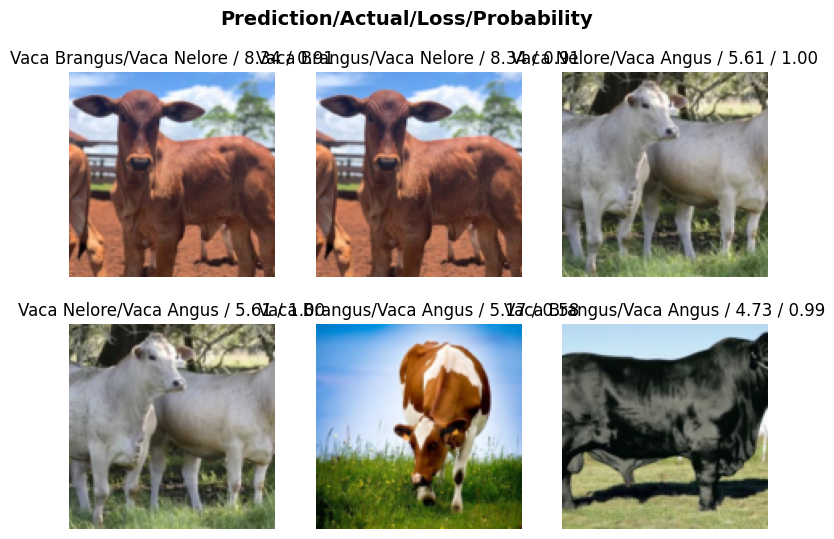

In [24]:
interp.plot_top_losses(6, nrows=2)

In [25]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [26]:
learn_inf = load_learner(path/'export.pkl') 
learn_inf.predict('/kaggle/input/test-set-cow/cow.jpg')


('Vaca Nelore', tensor(2), tensor([5.5072e-07, 2.0579e-07, 1.0000e+00]))

In [27]:
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}


In [28]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 98.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: python-multipart
    Found existing installation: python-multipart 0.0.9
    Uninstalling python-multipart-0.0.9:
      Successfully uninstalled python-multipart-0.0.9
  Attempting uninstall: starlette
    Found existing installation: starlette 0.37.2
    Uninstalling starlette-0.37.2:
      Successfully uninstalled starlette-0.37.2
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.111.0
    Uninstalling fastapi-0.111.0:
      Successfully uninstalled fastapi-0.111.0


In [29]:
title = "Cow breed classifier"
description = "A cow breed classifier trained a dataset with fastai. Created as a demo for Gradio and HuggingFace Spaces."
article="<p style='text-align: center'><a href='https://capataz.netlify.app/' target='_blank'>Capataz</a></p>"
 

In [30]:
import gradio as gr
image = gr.Image(height=192, width=192)
label = gr.Label()
examples:list = ['/kaggle/input/cow-sample/angus.jpg', '/kaggle/input/cow-sample/brangus.jpg',
                 '/kaggle/input/cow-sample/nelore.jpg']

intf = gr.Interface(fn=predict, inputs=image, outputs=label, examples=examples,
                    title=title,description=description,article=article)
intf.launch(inline=False)



* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://d49be883c22e04eb70.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
